# DS7331 Project: Phishing Dataset

- Hayoung Cheon
- Steven Cox
- Erika Dupond
- Miguel


## Mini-Lab: Logistic Regression and SVMs

You are to perform predictive analysis (classification) upon a data set: model the dataset using
methods we have discussed in class: logistic regression and support vector machines, and making
conclusions from the analysis.

### General Import

In [1]:
# general
import math
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# SKLearn
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.feature_extraction import FeatureHasher
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, SGDClassifier
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score
from collections import Counter
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)
warnings.filterwarnings("ignore")

TABLE_LAYOUT = [
    {'selector': 'table', 'props': [('width', '100%')]},
    {'selector': 'thead th', 'props': [('text-align', 'center')]},
    {'selector': 'td', 'props': [('text-align', 'left')]}
]

%matplotlib inline


In [2]:
# URL to the dataset
url = "https://archive.ics.uci.edu/static/public/967/phiusiil+phishing+url+dataset.zip"

# Read the CSV file from the URL, ignoring the first column (index 0)
df = pd.read_csv(url, encoding="utf-8")
df = df.drop("FILENAME", axis=1)  # Column "FILENAME" can be ignored.
print("\nShape of data:", df.shape)
df.head()



Shape of data: (235795, 55)


,URL,URLLength,Domain,DomainLength,IsDomainIP,TLD,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,URLCharProb,...,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
0,https://www.southbankmosaics.com,31,www.southbankmosaics.com,24,0,com,100.0,1.000000,0.522907,0.061933,...,0,0,1,34,20,28,119,0,124,1
1,https://www.uni-mainz.de,23,www.uni-mainz.de,16,0,de,100.0,0.666667,0.032650,0.050207,...,0,0,1,50,9,8,39,0,217,1
2,https://www.voicefmradio.co.uk,29,www.voicefmradio.co.uk,22,0,uk,100.0,0.866667,0.028555,0.064129,...,0,0,1,10,2,7,42,2,5,1
3,https://www.sfnmjournal.com,26,www.sfnmjournal.com,19,0,com,100.0,1.000000,0.522907,0.057606,...,1,1,1,3,27,15,22,1,31,1
4,https://www.rewildingargentina.org,33,www.rewildingargentina.org,26,0,org,100.0,1.000000,0.079963,0.059441,...,1,0,1,244,15,34,72,1,85,1


In [3]:
df.describe()

,URLLength,DomainLength,IsDomainIP,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,URLCharProb,TLDLength,NoOfSubDomain,HasObfuscation,...,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
count,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,...,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000
mean,34.573095,21.470396,0.002706,78.430778,0.845508,0.260423,0.055747,2.764456,1.164758,0.002057,...,0.237007,0.023474,0.486775,26.075689,6.333111,10.522305,65.071113,2.377629,49.262516,0.571895
std,41.314153,9.150793,0.051946,28.976055,0.216632,0.251628,0.010587,0.599739,0.600969,0.045306,...,0.425247,0.151403,0.499826,79.411815,74.866296,22.312192,176.687539,17.641097,161.027430,0.494805
min,13.000000,4.000000,0.000000,0.155574,0.000000,0.000000,0.001083,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,23.000000,16.000000,0.000000,57.024793,0.680000,0.005977,0.050747,2.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,27.000000,20.000000,0.000000,100.000000,1.000000,0.079963,0.057970,3.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,8.000000,2.000000,6.000000,12.000000,0.000000,10.000000,1.000000
75%,34.000000,24.000000,0.000000,100.000000,1.000000,0.522907,0.062875,3.000000,1.000000,0.000000,...,0.000000,0.000000,1.000000,29.000000,8.000000,15.000000,88.000000,1.000000,57.000000,1.000000
max,6097.000000,110.000000,1.000000,100.000000,1.000000,0.522907,0.090824,13.000000,10.000000,1.000000,...,1.000000,1.000000,1.000000,8956.000000,35820.000000,6957.000000,27397.000000,4887.000000,27516.000000,1.000000


### Helper Functions

In [4]:
# Helper functions
"""
# Optional Code: This is just to get the exercise going.

- Since URL and others high cardinality, can cause the model not to scale.
- In Addition, it is expensive computationally to produce such high cardinality features.
- There is an opportunity to do a Transformation to continuous attribute

Reference on: 
Julie Moeyersoms, David Martens
Including high-cardinality attributes in predictive models: A case study in churn prediction in the energy sector, Decision Support Systems, Volume 72,2015
Pages 72-81,
ISSN 0167-9236
https://www.sciencedirect.com/science/article/pii/S0167923615000275#s0120

Hash Encoding:  https://towardsdatascience.com/4-ways-to-encode-categorical-features-with-high-cardinality-1bc6d8fd7b13/
"""


def shannon_entropy(text):
    if not text or not isinstance(text, str):
        return 0
    counts = Counter(text)
    probs = [freq / len(text) for freq in counts.values()]
    return -sum(p * np.log2(p) for p in probs if p > 0)


def pre_process_data(
    input_df, drop_cols=[], use_entropy=True, include_aggregates=False
):
    df = input_df.copy()
    y = df["label"]

    X = df.drop(columns=[col for col in drop_cols if col in df.columns] + ["label"])

    binary_cols = X.nunique() == 2
    for col in X.columns[binary_cols]:
        X[col] = X[col].astype(int)

    categorical_cols = X.select_dtypes(include=["object"]).columns
    low_cardinality_cols = [col for col in categorical_cols if X[col].nunique() < 200]
    high_cardinality_cols = [col for col in categorical_cols if X[col].nunique() >= 200]

    if use_entropy:
        for col in ["URL", "Domain", "Title"]:
            if col in df.columns:
                X[f"{col}_entropy"] = df[col].astype(str).apply(shannon_entropy)
                print(f"Entropy for {col}: {X[f'{col}_entropy'].mean():.4f}")

        X = X.drop(
            columns=[col for col in high_cardinality_cols if col in X.columns],
            errors="ignore",
        )
    else:
        hashed_dfs = []
        for col in high_cardinality_cols:
            unique_count = X[col].nunique()
            n_features = (
                10 if unique_count < 200 else min(max(unique_count // 10, 10), 500)
            )
            print(
                f"Hashing {col} with {n_features} features (from {unique_count} unique values)"
            )
            hasher = FeatureHasher(n_features=n_features, input_type="string")
            hashed_features = hasher.fit_transform(
                X[col].astype(str).values.reshape(-1, 1)
            )
            hashed_df = pd.DataFrame(
                hashed_features.toarray(),
                columns=[f"{col}_hash_{i}" for i in range(n_features)],
            )
            hashed_dfs.append(hashed_df)
            X = X.drop(columns=[col])
        if hashed_dfs:
            hashed_combined = pd.concat(hashed_dfs, axis=1).reset_index(drop=True)
            X = pd.concat([X.reset_index(drop=True), hashed_combined], axis=1)

    for col in low_cardinality_cols:
        dummies = pd.get_dummies(X[col], prefix=col, drop_first=True)
        X = pd.concat([X.drop(columns=[col]), dummies], axis=1)
        print(f"Dummy encoding {col} with {dummies.shape[1]} features")

    if include_aggregates:
        special_cols = [
            "NoOfEqualsInURL",
            "NoOfQMarkInURL",
            "NoOfAmpersandInURL",
            "NoOfOtherSpecialCharsInURL",
        ]
        resource_cols = ["NoOfImage", "NoOfCSS", "NoOfJS", "NoOfExternalRef"]
        if all(col in df.columns for col in special_cols):
            X["TotalSpecialChars"] = df[special_cols].sum(axis=1)
            print("Added TotalSpecialChars")
        if all(col in df.columns for col in resource_cols):
            X["TotalExternalResources"] = df[resource_cols].sum(axis=1)
            print("Added TotalExternalResources")

    return X, y


def check_leakage(df, columns=["URL", "Title"]):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    leakages = []
    for i, col in enumerate(columns):
        if col in df.columns:
            unique_vals = df.groupby(col)["label"].nunique()
            leaks = (unique_vals == 1).sum()
            total = len(unique_vals)
            leak_pct = leaks / total

        leakages.append(
            {
                "feature": col,
                "total": total,
                "leaks": leaks,
                "leak_pct": float(leak_pct * 100),
            }
        )

        categories = ["Leakage", "No Leakage"]
        values = [leaks, total - leaks]

        bars = axes[i].bar(categories, values)
        axes[i].set_title(f"Data Leakage in {col} Column")
        axes[i].set_ylabel("Count of Unique Values")

        for bar in bars:
            height = bar.get_height()
            axes[i].annotate(
                f"{height}",
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha="center",
                va="bottom",
            )

    plt.tight_layout()
    plt.show()

    leakages = pd.DataFrame(leakages)
    display(leakages)


def pca_analysis(df):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df)

    pca = PCA().fit(X_scaled)
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel("Number of Components")
    plt.ylabel("Cumulative Explained Variance")
    plt.title("PCA: Explained Variance")
    plt.grid(True)
    plt.show()

# Validation Function
def validate_holdout(X_train, X_holdout, y_pred, y_holdout):
    train_hashes = pd.util.hash_pandas_object(pd.DataFrame(X_train)).values
    holdout_hashes = pd.util.hash_pandas_object(pd.DataFrame(X_holdout)).values
    overlap = np.intersect1d(train_hashes, holdout_hashes)
    print(f"Number of overlapping samples: {len(overlap)}")

    cm = confusion_matrix(y_holdout, y_pred)
    tn, fp, fn, tp = cm.ravel()

    accuracy = accuracy_score(y_holdout, y_pred)
    precision = precision_score(y_holdout, y_pred, zero_division=0)
    recall = recall_score(y_holdout, y_pred, zero_division=0)
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0.0
    f1 = f1_score(y_holdout, y_pred, zero_division=0)

    metrics_df = pd.DataFrame({
        "Metric": [
            "Accuracy",
            "Precision (PPV)",
            "Recall (Sensitivity)",
            "Specificity (TNR)",
            "Negative Predictive Value (NPV)",
            "F1 Score",
        ],
        "Value": [accuracy, precision, recall, specificity, npv, f1],
    })

    metrics_df["Value"] = (metrics_df["Value"] * 100).round(2).astype(str) + "%"
    display(metrics_df)

    conf_matrix_df = pd.DataFrame(
        cm,
        index=["Actual 0 (Non-phishing)", "Actual 1 (Phishing)"],
        columns=["Predicted 0 (Non-phishing)", "Predicted 1 (Phishing)"]
    )
    display(conf_matrix_df) 

    labels = ['0', '1']
    conf_mat = confusion_matrix(y_holdout, y_pred)

    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

#### PCA Analysis and Scaling

Hashing URL with 500 features (from 235370 unique values)
Hashing Domain with 500 features (from 220086 unique values)
Hashing TLD with 69 features (from 695 unique values)
Hashing Title with 500 features (from 197874 unique values)


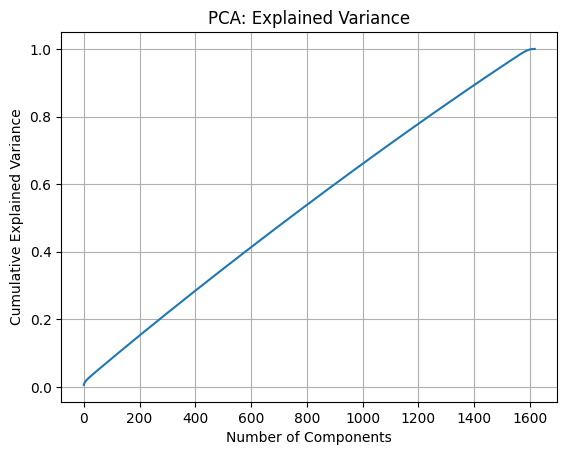

In [5]:
# PCA Check on preprocessed data
"""
Pre-process and encoding features. We are exploring those categorical columns looking and addressing:

- High cardinality features and how with more advanced encoding (hashing) can improve the variance and reducing the feature space.
"""
X, y = pre_process_data(df, use_entropy=False)
pca_analysis(X)

##### PCA Summary - Feature Space

The feature space has 1619 features (original + hashed)

###### Explained Variance Distribution

- The cumulative explained variance curve increases linearly with the number of components.
- About 1200 components are needed to explain ~80% of the total variance.
- The first few components do not capture a dominant share of variance, suggesting:
    - Our data is high-dimensional, with variance spread out across many features.
    - Little redundancy is apparent; most features contribute independently to variance.

###### Implications

- Dimensionality reduction (PCA) won’t significantly condense information into a small number of components.
- The hashing of high-cardinality features (e.g., URL, Title) spreads variance across many features, as each hashed bucket captures partial variance.

### Encoding and Finding High Cardinality Features


In [6]:
# Logistic Regression with Lasso with Hashed and Dummy encoded data - Warning this will take a while
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# X_train, X_test, y_train, y_test = train_test_split(
#     X_scaled, y, test_size=0.3, stratify=y, random_state=42
# )

# lasso = LogisticRegression(
#     C=0.05,
#     verbose=2,
#     l1_ratio=0.5,
#     max_iter=250,
#     solver="saga",
#     penalty="elasticnet",
# )

# lasso.fit(X_train, y_train)
# y_pred_proba = lasso.predict_proba(X_test)[:, 1]
# auc_lasso = roc_auc_score(y_test, y_pred_proba)
# print(f"Logistic Regression AUC: {auc_lasso:.3f}")

##### Leakages summary


- Initial Findings
  - Engineered hashed features from `URL` and `Title`, those categorical features initially displayed significant signals (domain knowledge).

- Discovery of Data Leakage
  - Analysis showed:
    - 100% of `URL`s correspond to a unique label – direct leakage.
    - 99.9% of `Title`s correspond to a unique label.
  - Hashing did not prevent leakage, as uniqueness was preserved in the hash.

- Dimensionality & Redundancy Check
  - PCA revealed:
    - ~80% variance explained by ~1200 components of ~1600 total features.

- Logistic Regression Modeling
  - Trained models with scikit-learn and PyTorch (LASSO).
  - Observed AUC=1.0 – clear overfitting due to leakage from raw `URL` and `Title`.

- Key Decision: Feature Dropping
  - Dropped `URL`, `Title`, and their hashed versions to eliminate data leakage.
  - Retained engineered features (e.g., `URLLength`, `ObfuscationRatio`, `LetterRatioInURL`).
- Recognized Logistic Regression’s limitations for high-dimensional, correlated data.

- Learning & Next Steps
  - Valuable lesson on how high-cardinality features can introduce leakage.
  - What to do next:
    - Focus on regularization, cross-validation, and robust validation strategies.


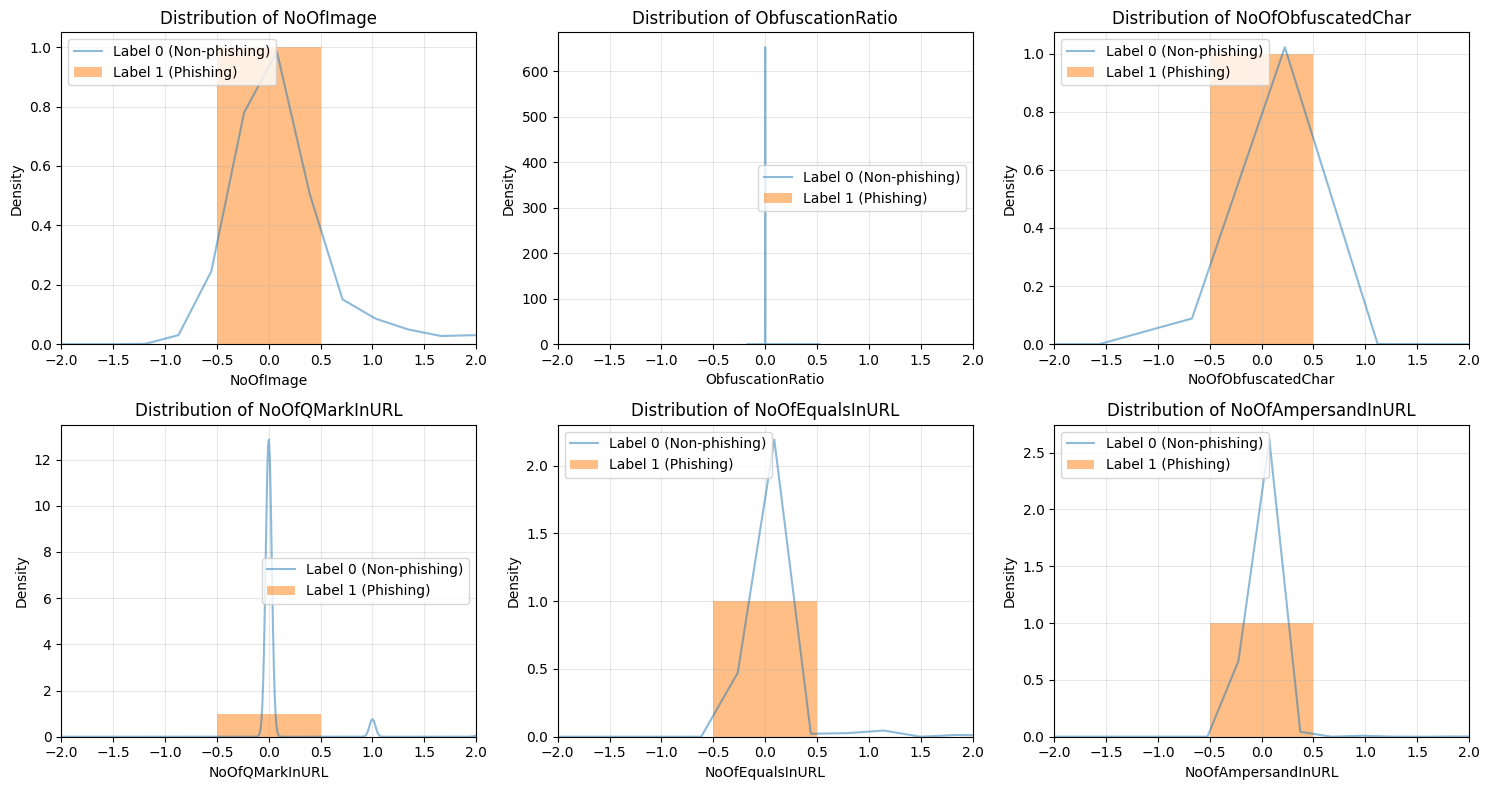

,NoOfImage,ObfuscationRatio,NoOfObfuscatedChar,NoOfQMarkInURL,NoOfEqualsInURL,NoOfAmpersandInURL
count,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000
mean,26.075689,0.000138,0.024861,0.029403,0.062241,0.025056
std,79.411815,0.003817,1.876249,0.193505,0.934704,0.836448
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,29.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,8956.000000,0.348000,447.000000,4.000000,176.000000,149.000000


In [7]:
# Finding features that could be dropped
def plot_relation_dist(ax, df, feature):
    data_0 = df[df['label'] == 0][feature]
    data_1 = df[df['label'] == 1][feature]

    if data_0.std() > 0:
        data_0.plot(kind='kde', ax=ax, label='Label 0 (Non-phishing)', alpha=0.5)

    ax.hist(data_1, bins=1, range=(-0.5,0.5), density=True, alpha=0.5, label='Label 1 (Phishing)')

    ax.set_xlim(-2, 2)
    ax.set_xlabel(feature)
    ax.set_ylabel('Density')
    ax.set_title(f'Distribution of {feature}')
    ax.grid(alpha=0.3)
    ax.legend()

potential_drop = [
    "NoOfImage",
    "ObfuscationRatio",
    "NoOfObfuscatedChar",
    "NoOfQMarkInURL",
    "NoOfEqualsInURL",
    "NoOfAmpersandInURL",
]

n_features = len(potential_drop)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

for i, feature in enumerate(potential_drop):
    plot_relation_dist(axes[i], df, feature)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

df[potential_drop].describe()

Noticed these features were not that useful; starting with stats analysis, the low mean and standard deviation (close to 0) raised suspicions. Visualizations confirmed these features could act as shortcuts for class separation, especially in Logistic Regression, leading to overfitting and poor generalization.

### Modeling

#### Feature Selection


Features with high skewness:
NoOfCSS                       464.404031
NoOfJS                        140.435761
NoOfEmptyRef                  106.826225
NoOfiFrame                     97.677347
NoOfDegitsInURL                94.877574
NoOfPopup                      84.952694
NoOfExternalRef                65.900247
NoOfSelfRef                    60.381378
NoOfLettersInURL               58.402581
URLLength                      53.321737
LineOfCode                     53.072297
LargestLineLength              48.179926
NoOfOtherSpecialCharsInURL     47.428522
DegitRatioInURL                 3.244523
DomainLength                    2.513397
NoOfSubDomain                   1.809400
TLDLength                       1.663518
SpacialCharRatioInURL           1.184134
TLDLegitimateProb               0.073090
DomainTitleMatchScore          -0.008735
LetterRatioInURL               -0.066358
URLTitleMatchScore             -0.089085
URLCharProb                    -1.064291
CharContinuationRate       

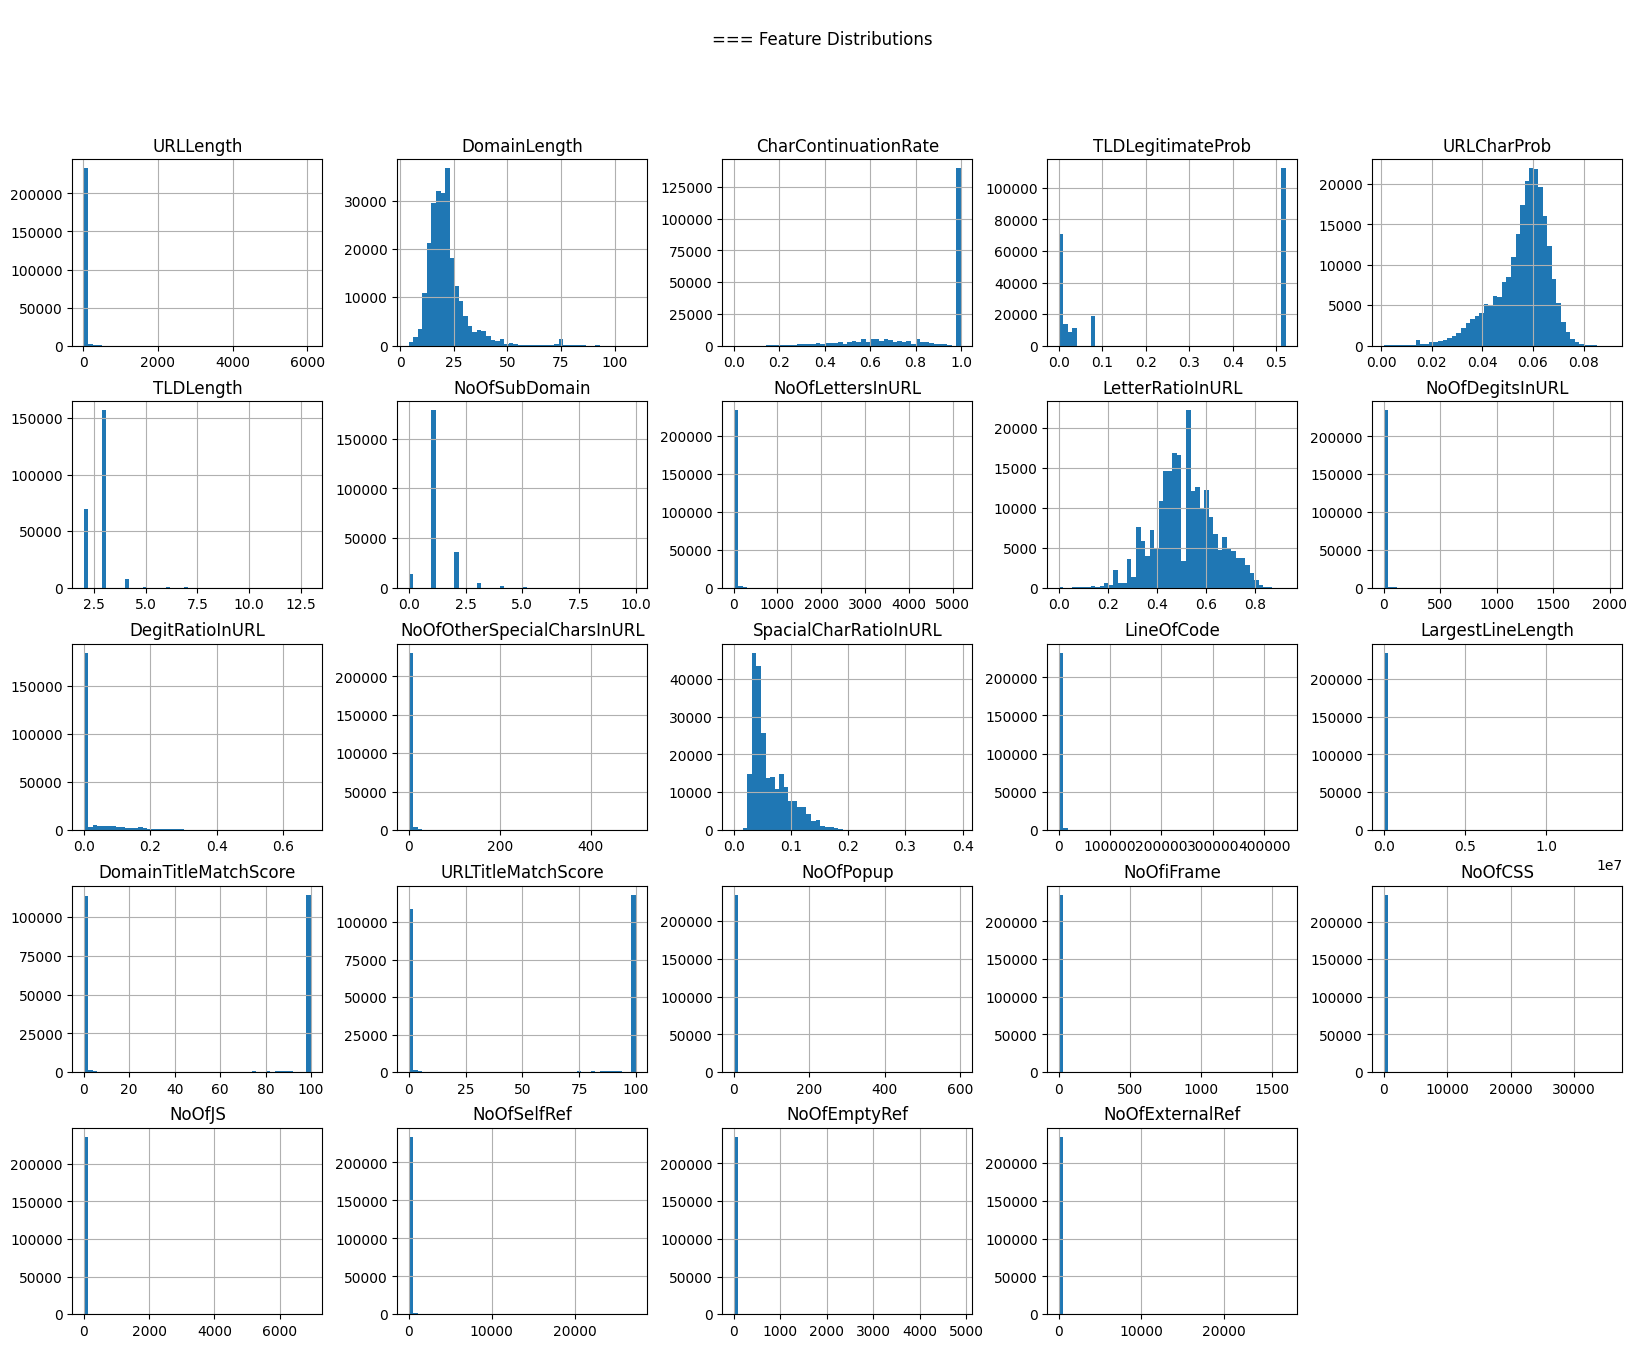

In [8]:
## Feature Selection
base_drop = [
    "URL",
    "Domain",
    "Title",
    "TLD",
    "URLSimilarityIndex",
    "HasSocialNet",
    "HasCopyrightInfo",
    "HasTitle",
    "IsHTTPS",
    "IsResponsive",
    "IsDomainIP",
    "HasDescription",
    "HasObfuscation",
    "HasSubmitButton",
    "HasExternalSubmitForm",
]
potential_drop = [
    "NoOfImage",
    "ObfuscationRatio",
    "NoOfObfuscatedChar",
    "NoOfQMarkInURL",
    "NoOfEqualsInURL",
    "NoOfAmpersandInURL",
]
drop = base_drop + potential_drop

X_final, y_final = pre_process_data(
    df, drop_cols=drop, use_entropy=False, include_aggregates=False
)

continuous_features = [col for col in X_final.columns if X_final[col].nunique() > 2]

skewness = X_final[continuous_features].skew().sort_values(ascending=False)
print(f"\nFeatures with high skewness:")
print(skewness)

low_variance = X_final[continuous_features].std().sort_values()
print(f"\n=== Features with low variance:")
print(low_variance[low_variance < 0.1])

X_final[continuous_features].hist(bins=50, figsize=(20,15))
plt.suptitle("\n=== Feature Distributions")
plt.show()


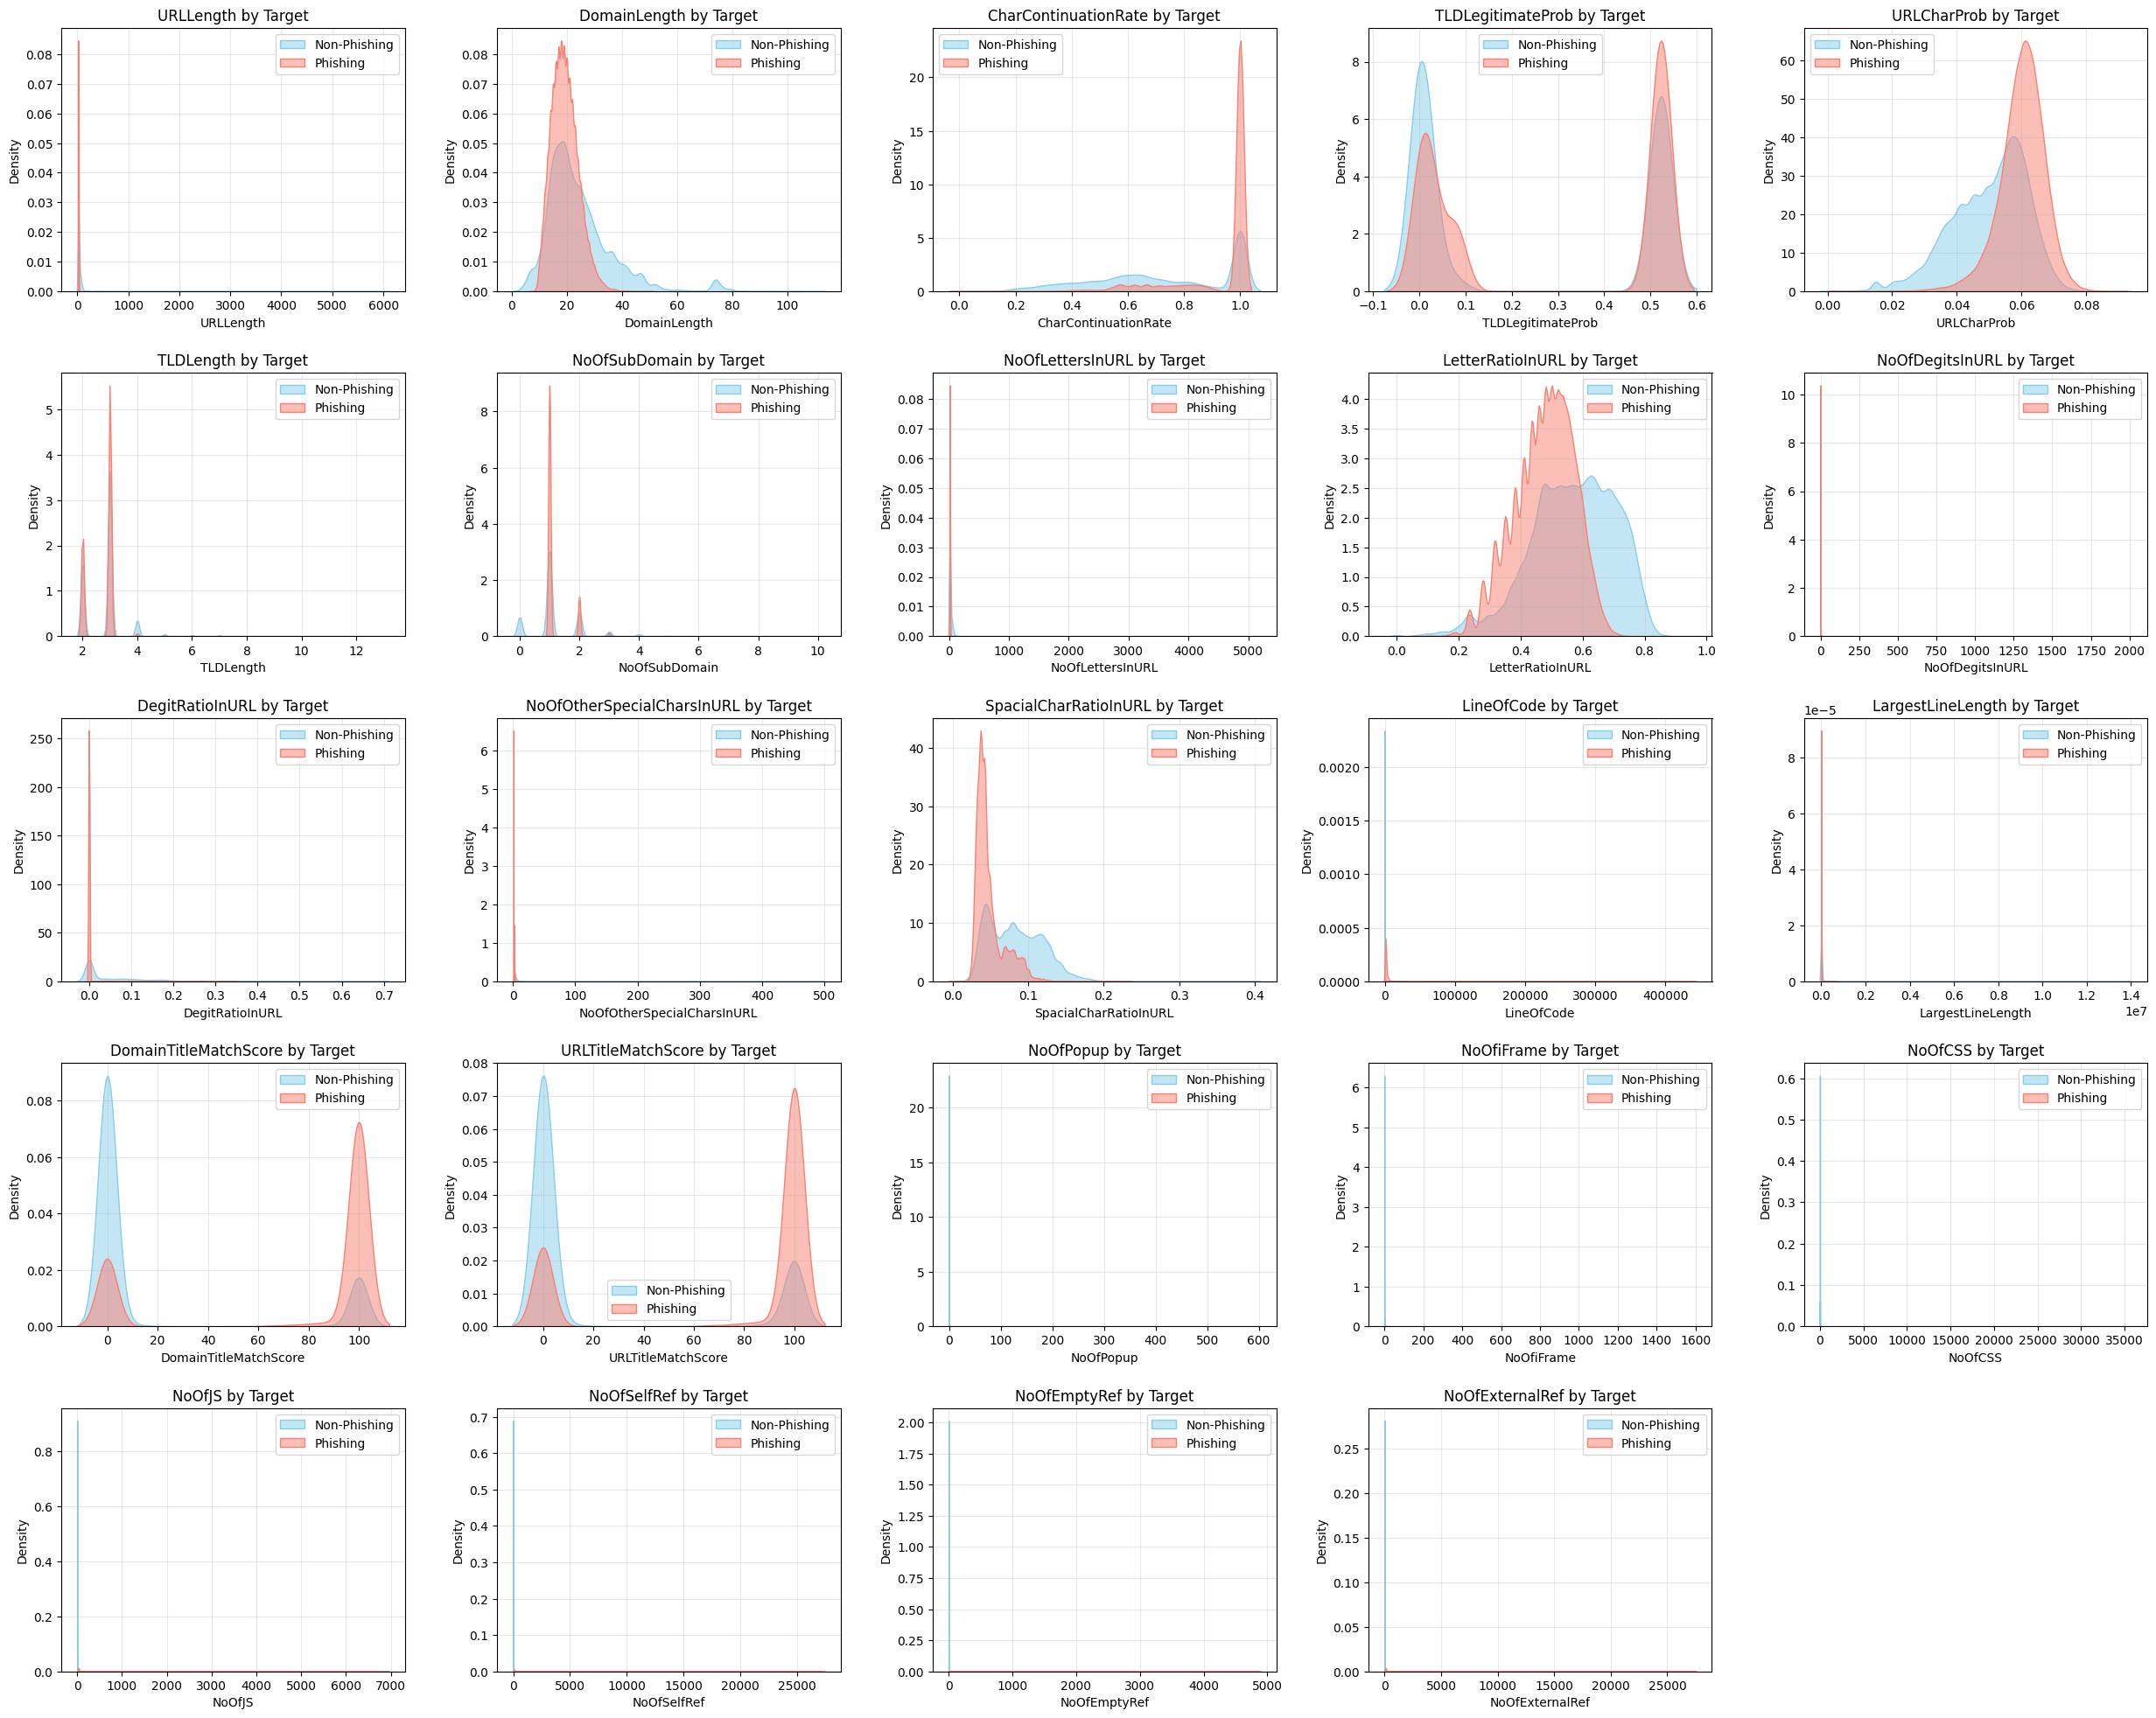


Correlations with Target:



,Pearson,Spearman
DomainTitleMatchScore,0.584905,0.569761
URLTitleMatchScore,0.539419,0.525153
SpacialCharRatioInURL,-0.533537,-0.527416
HasHiddenFields,0.507731,0.507731
HasFavicon,0.493711,0.493711
URLCharProb,0.469749,0.459111
CharContinuationRate,0.467735,0.470010
DegitRatioInURL,-0.432032,-0.536274
Robots,0.392620,0.392620
NoOfJS,0.373500,0.823015


In [9]:
## Feature Analysis
numerical_cols = [
    col for col in X_final.select_dtypes(include=['float64', 'int64'])
    if X_final[col].nunique() > 2
]

num_cols = 5
num_rows = int(np.ceil(len(numerical_cols) / num_cols))
fig, axes = plt.subplots(num_rows, num_cols, figsize=(5*num_cols, 4*num_rows))
axes = axes.flatten()

y_aligned = y_final.reset_index(drop=True)
X_aligned = X_final.reset_index(drop=True)

for i, feature in enumerate(numerical_cols):
    ax = axes[i]
    data_non_phishing = X_aligned[feature][y_aligned == 0].dropna()
    data_phishing = X_aligned[feature][y_aligned == 1].dropna()

    if data_non_phishing.nunique() > 1:
        sns.kdeplot(data_non_phishing, fill=True, color='skyblue', label='Non-Phishing', alpha=0.5, ax=ax)
    if data_phishing.nunique() > 1:
        sns.kdeplot(data_phishing, fill=True, color='salmon', label='Phishing', alpha=0.5, ax=ax)

    ax.set_title(f"{feature} by Target")
    ax.set_xlabel(feature)
    ax.set_ylabel('Density')
    ax.legend()
    ax.grid(alpha=0.3)

for j in range(len(numerical_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(pad=2.0)
plt.show()


df_temp = X_final.copy()
df_temp['label'] = y_final
corr_pearson = df_temp.corr(method='pearson')['label'].sort_values(ascending=False)
corr_spearman = df_temp.corr(method='spearman')['label'].sort_values(ascending=False)

corr_df = pd.DataFrame({'Pearson': corr_pearson, 'Spearman': corr_spearman}).drop(index='label')
print("\nCorrelations with Target:\n")
display(corr_df.sort_values(by='Pearson', key=abs, ascending=False))

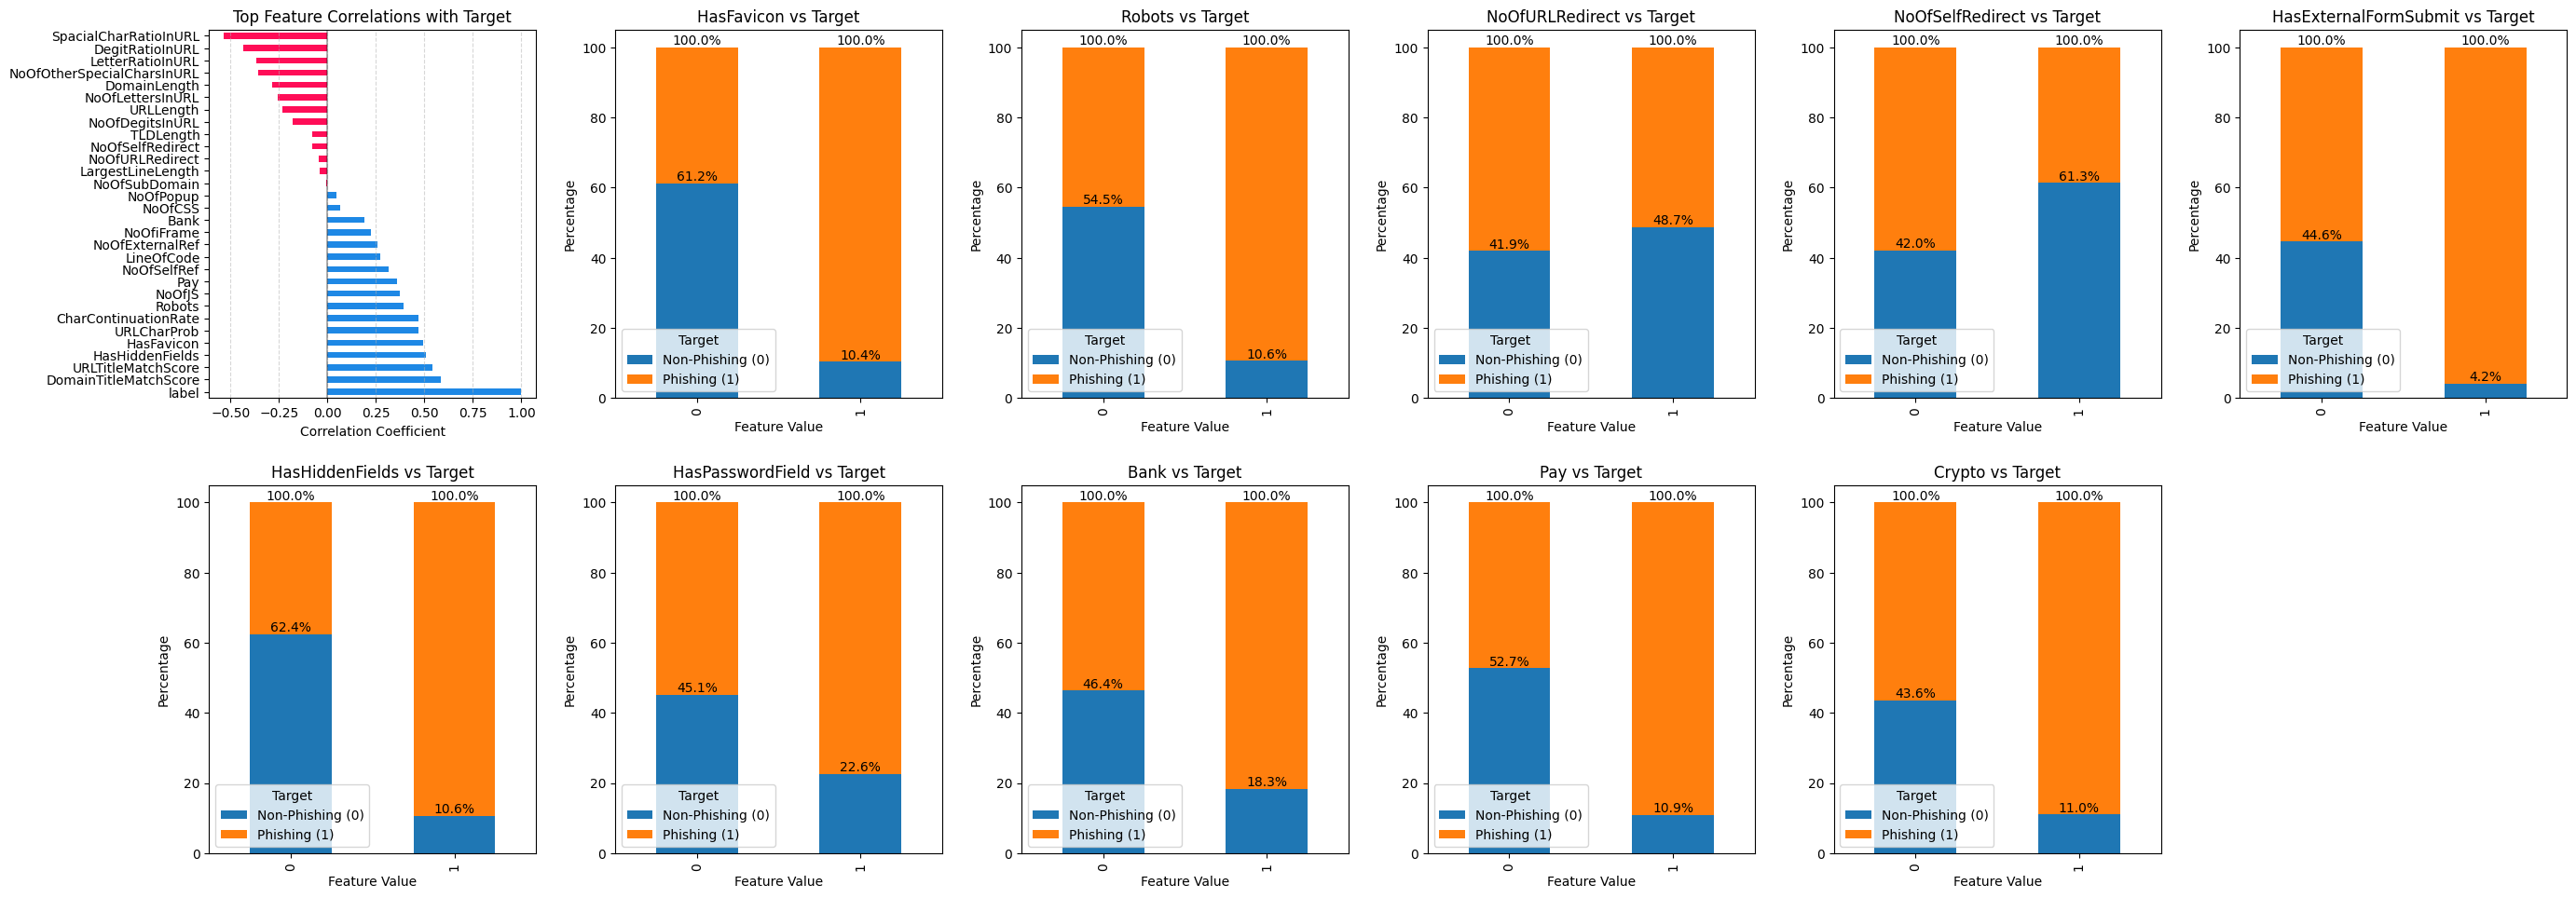

In [10]:
## Feature Analysis

feature_correlations = X_final.copy()
feature_correlations["label"] = y_final
corrs = feature_correlations.corr()["label"].sort_values(ascending=False)

binary_features = []
for col in X_final.columns:
    unique_vals = X_final[col].nunique()
    if unique_vals == 2:
        binary_features.append(col)

num_cols = 6
total_plots = 1 + len(binary_features)
num_rows = math.ceil(total_plots / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(28, 5 * num_rows))
axes = axes.flatten()

top_n = 15
top_corrs = corrs.iloc[:top_n]
bottom_corrs = corrs.iloc[-top_n:] if len(corrs) > top_n else pd.Series()
plot_corrs = pd.concat([top_corrs, bottom_corrs])
colors = ["#1e88e5" if c > 0 else "#ff0d57" for c in plot_corrs]

ax0 = axes[0]
plot_corrs.plot(kind="barh", ax=ax0, color=colors)
ax0.set_title("Top Feature Correlations with Target", fontsize=12)
ax0.axvline(x=0, color="black", linestyle="-", alpha=0.3)
ax0.grid(axis="x", linestyle="--", alpha=0.5)
ax0.set_xlabel("Correlation Coefficient")

for i, feature in enumerate(binary_features):
    if i + 1 < len(axes):
        ax = axes[i + 1]
        ct = pd.crosstab(X_final[feature], y_final, normalize="index") * 100

        ct.plot(kind="bar", stacked=True, ax=ax)

        for c in ax.containers:
            ax.bar_label(c, fmt="%.1f%%")

        ax.set_title(f"{feature} vs Target", fontsize=12)
        ax.set_ylabel("Percentage")
        ax.set_xlabel("Feature Value")
        ax.legend(title="Target", labels=["Non-Phishing (0)", "Phishing (1)"])

        ct_raw = pd.crosstab(X_final[feature], y_final)
        total = ct_raw.sum().sum()
        perfect_split = (ct_raw == 0).any().any()

        if perfect_split:
            ax.text(
                0.5,
                -0.15,
                "Potential data leakage detected!",
                horizontalalignment="center",
                color="red",
                transform=ax.transAxes,
                fontsize=11,
            )

for i in range(total_plots, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout(pad=2.0)
plt.show()

After deep dive after looking those features where mean and std deviation looked suspicious, we decided to deep dive on the features for skewness and low variance. Those were candidates to log transform to have a more constant variance that makes more appropriate for Logistic Regression.

### Creating Training and Testing Datasets

In [11]:
### Split data 80/20
X_train, X_holdout, y_train, y_holdout = train_test_split(
    X_final, y_final, test_size=0.2, random_state=42, stratify=y_final
)

### Logistic Regression

For the modeling phase we decided to create a pipeline where we transform those candidate features into log space and then standardize the rest of the features. Seemed appropriate after multiple runs to expose the model to a new data by creating a holdout set.



Hold-out AUC: 1.000
Hold-out Accuracy: 0.998
Hold-out F1 Score: 0.998
Number of overlapping samples: 0


,Metric,Value
0,Accuracy,99.77%
1,Precision (PPV),99.69%
2,Recall (Sensitivity),99.9%
3,Specificity (TNR),99.59%
4,Negative Predictive Value (NPV),99.87%
5,F1 Score,99.8%


,Predicted 0 (Non-phishing),Predicted 1 (Phishing)
Actual 0 (Non-phishing),20106,83
Actual 1 (Phishing),27,26943


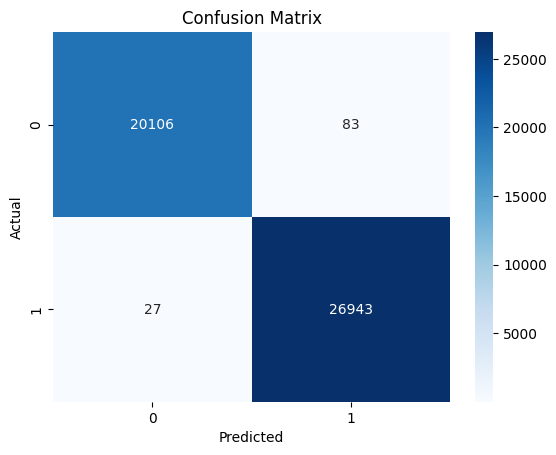

In [12]:
## Logistic Regression
high_skew_features = [
    "NoOfCSS",
    "NoOfJS",
    "NoOfEmptyRef",
    "NoOfiFrame",
    "NoOfDegitsInURL",
    "NoOfPopup",
    "NoOfExternalRef",
    "NoOfSelfRef",
    "NoOfLettersInURL",
    "URLLength",
    "LineOfCode",
    "LargestLineLength",
    "NoOfOtherSpecialCharsInURL",
    "DegitRatioInURL",
    "DomainLength",
    "NoOfSubDomain",
    "TLDLength",
    "SpacialCharRatioInURL",
]
standard_scale_features = [
    col for col in continuous_features if col not in high_skew_features
]

lr_preprocessor = ColumnTransformer(
    transformers=[
        ("log", FunctionTransformer(np.log1p, validate=True), high_skew_features),
        ("scale", StandardScaler(), standard_scale_features),
    ],
    remainder="passthrough",
)

lr_lasso = LogisticRegression(
    penalty="l1",
    solver="saga",
    C=0.01,
    max_iter=5000,
    n_jobs=-1,
    random_state=42,
)

lr_pipeline = Pipeline([("preprocessor", lr_preprocessor), ("lasso", lr_lasso)])


lr_pipeline.fit(X_train, y_train)
y_pred_proba = lr_pipeline.predict_proba(X_holdout)[:, 1]
y_pred = lr_pipeline.predict(X_holdout)

holdout_auc = roc_auc_score(y_holdout, y_pred_proba)
holdout_acc = accuracy_score(y_holdout, y_pred)
holdout_f1 = f1_score(y_holdout, y_pred)

print(f"\nHold-out AUC: {holdout_auc:.3f}")
print(f"Hold-out Accuracy: {holdout_acc:.3f}")
print(f"Hold-out F1 Score: {holdout_f1:.3f}")

validate_holdout(X_train, X_holdout, y_pred, y_holdout)


#### Weights - Coefficients

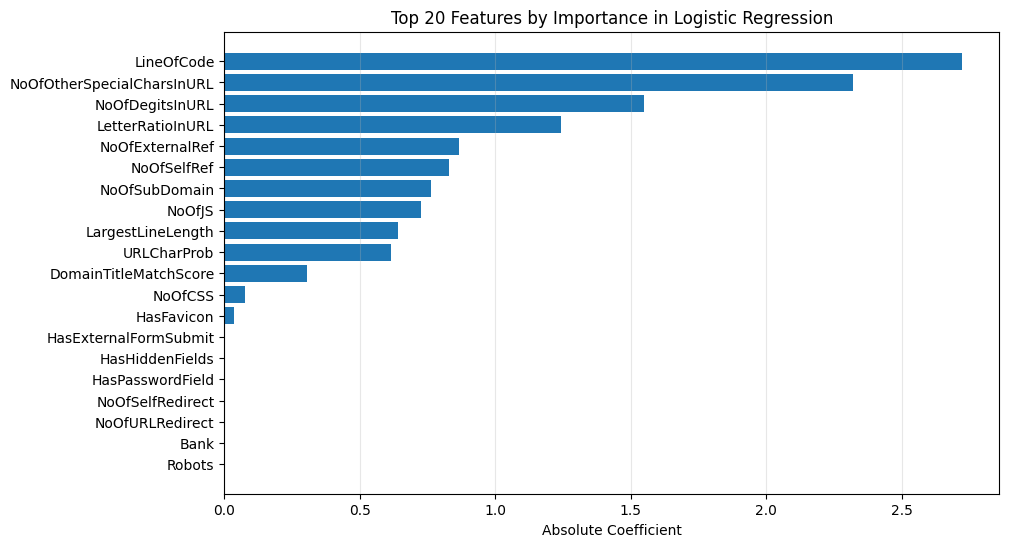

In [13]:
## Logistic Regression
log_features = lr_preprocessor.transformers_[0][2]
scale_features = lr_preprocessor.transformers_[1][2]
passthrough_features = [f for f in X_final.columns if f not in log_features + scale_features]

final_feature_names = log_features + scale_features + passthrough_features

coefficients = lr_pipeline.named_steps['lasso'].coef_.flatten()

feature_weights_df = pd.DataFrame({
    "Feature": final_feature_names,
    "Coefficient": coefficients,
    "AbsoluteCoefficient": np.abs(coefficients)
}).sort_values(by="AbsoluteCoefficient", ascending=False)

N = 20
top_features = feature_weights_df.head(N)

plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'][::-1], top_features['AbsoluteCoefficient'][::-1])
plt.xlabel('Absolute Coefficient')
plt.title(f'Top {N} Features by Importance in Logistic Regression')
plt.grid(axis='x', alpha=0.3)
plt.show()

The bar chart shows the **top 20 features ranked by the absolute value of their coefficients**, indicating their relative importance in the phishing classification task.

##### Interpretation of Top Features:

- **`LineOfCode`**: This feature has the largest absolute coefficient, suggesting that the number of lines in a page's HTML or script is a very strong predictor. Phishing pages may exhibit more or less complexity in their structure, which this feature captures.
  
- **`NoOfOtherSpecialCharsInURL`**: A high number of unusual characters (e.g., `@`, `%`, `=`, `&`) is commonly associated with phishing URLs that try to obfuscate or manipulate the URL structure to mislead users.

- **`NoOfDegitsInURL`**: Excessive digits can be indicative of dynamically generated or obfuscated phishing URLs. Attackers often include numbers to imitate legitimate patterns or evade detection.

- **`LetterRatioInURL`**: This feature reflects how "word-like" a URL is. A low ratio may suggest a suspicious, machine-generated structure.

- **`NoOfExternalRef`** and **`NoOfSelfRef`**: These capture how the page links to other resources. Phishing pages often rely on external resources (e.g., fake login pages hosted elsewhere), while lacking legitimate internal structure.

- **`NoOfSubDomain`**: A high number of subdomains may indicate deceptive structures, such as `login.bank.example.com.phishy.net`.

- **`HasFavicon`**, **`HasExternalFormSubmit`**, **`HasHiddenFields`**: These binary features flag suspicious HTML behaviors. For instance, phishing pages may use hidden form fields or submit data to external domains.

##### Key Findings:

1. **High Discriminative Power**: Features like `LineOfCode` or `NoOfSpecialChars` are highly distinctive between phishing and legitimate pages, enabling the model to learn clear boundaries.

2. **Reflect Attacker Behavior**: Many of the top features directly correlate with common tactics used in phishing — such as obfuscation, hiding intent, or spoofing domain structures.

3. **Predictable Patterns**: Features with low variance across classes contribute less to classification. In contrast, high-variance features that differ significantly between phishing and non-phishing examples are prioritized.

##### Conclusion:

The weights from Logistic Regression provide an interpretable way to understand feature importance. In this task, features related to **URL structure**, **HTML complexity**, and **form behavior** are most influential — aligning well with known characteristics of phishing attacks. This insight not only strengthens model transparency but can also guide future feature engineering and threat analysis.


### SVM - Stochastic Gradient Descent


Hold-out AUC: 0.998
Hold-out Accuracy: 0.982
Hold-out F1 Score: 0.984
Number of overlapping samples: 0


,Metric,Value
0,Accuracy,98.2%
1,Precision (PPV),99.31%
2,Recall (Sensitivity),97.53%
3,Specificity (TNR),99.1%
4,Negative Predictive Value (NPV),96.77%
5,F1 Score,98.41%


,Predicted 0 (Non-phishing),Predicted 1 (Phishing)
Actual 0 (Non-phishing),20007,182
Actual 1 (Phishing),667,26303


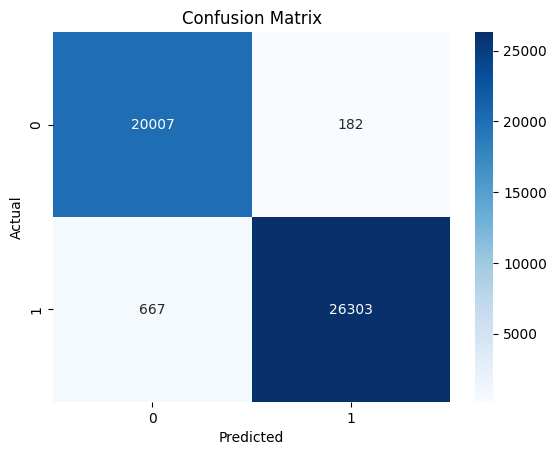

In [14]:
# SVM
to_scale = standard_scale_features + high_skew_features

preprocessor = ColumnTransformer(
    transformers=[
        ("scale", StandardScaler(), to_scale),
    ],
    remainder="passthrough",
)

sdg = SGDClassifier(loss='hinge', alpha=0.01, penalty='l1', random_state=42)
pipeline = Pipeline([("preprocessor", preprocessor), ("sdg", sdg)])


pipeline.fit(X_train, y_train)
y_decision = pipeline.decision_function(X_holdout)
y_pred = pipeline.predict(X_holdout)

holdout_auc = roc_auc_score(y_holdout, y_decision)
holdout_acc = accuracy_score(y_holdout, y_pred)
holdout_f1 = f1_score(y_holdout, y_pred)

print(f"\nHold-out AUC: {holdout_auc:.3f}")
print(f"Hold-out Accuracy: {holdout_acc:.3f}")
print(f"Hold-out F1 Score: {holdout_f1:.3f}")

validate_holdout(X_train, X_holdout, y_pred, y_holdout)

#### Insight into chosen support vectors
SGDClassifier with hinge loss approximates an SVM but does not explicitly expose support vecotrs like SVC does.
However, by using `decision_function(X)` we can get margin distances to find points near the margin. These will be rough proxy of support vectors.


#### Margins for Decision Scores

In [15]:
# Decision scores
decision_scores = pipeline.decision_function(X_holdout)

threshold = 0.1
margin_indices = np.where(np.abs(decision_scores) < threshold)[0]
near_margin_points = X_holdout.iloc[margin_indices]

print(f"Approximate 'support vector' candidates (near margin): {len(near_margin_points)}")
display(near_margin_points)

Approximate 'support vector' candidates (near margin): 465


,URLLength,DomainLength,CharContinuationRate,TLDLegitimateProb,URLCharProb,TLDLength,NoOfSubDomain,NoOfLettersInURL,LetterRatioInURL,NoOfDegitsInURL,...,HasHiddenFields,HasPasswordField,Bank,Pay,Crypto,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef
95534,25,18,1.000000,0.522907,0.058259,3,1,12,0.480,0,...,0,0,1,1,0,0,1,0,0,2
22069,19,12,1.000000,0.522907,0.066023,3,1,6,0.316,0,...,0,0,0,0,0,0,0,1,0,28
7938,29,22,0.866667,0.028555,0.054164,2,2,15,0.517,0,...,0,0,0,0,0,5,2,33,0,0
62783,27,20,0.769231,0.028555,0.053977,2,2,13,0.481,0,...,0,0,1,1,0,1,3,4,0,88
177217,27,20,1.000000,0.522907,0.067241,3,1,14,0.519,0,...,0,0,0,1,0,1,1,0,0,34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228291,22,15,1.000000,0.522907,0.052646,3,1,9,0.409,0,...,1,0,0,1,0,1,1,1,0,9
186850,27,20,0.769231,0.009442,0.060358,2,2,13,0.481,0,...,1,0,0,0,0,0,1,15,0,20
162448,29,22,1.000000,0.522907,0.071321,3,1,16,0.552,0,...,0,0,0,0,0,2,2,16,0,5
103816,25,18,0.727273,0.010086,0.058669,2,2,11,0.440,0,...,0,0,0,1,0,0,4,18,2,17


,URLLength,DomainLength,CharContinuationRate,TLDLegitimateProb,URLCharProb,TLDLength,NoOfSubDomain,NoOfLettersInURL,LetterRatioInURL,NoOfDegitsInURL,...,HasPasswordField,Bank,Pay,Crypto,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
95534,25,18,1.000000,0.522907,0.058259,3,1,12,0.480,0,...,0,1,1,0,0,1,0,0,2,1
22069,19,12,1.000000,0.522907,0.066023,3,1,6,0.316,0,...,0,0,0,0,0,0,1,0,28,1
7938,29,22,0.866667,0.028555,0.054164,2,2,15,0.517,0,...,0,0,0,0,5,2,33,0,0,1
62783,27,20,0.769231,0.028555,0.053977,2,2,13,0.481,0,...,0,1,1,0,1,3,4,0,88,1
177217,27,20,1.000000,0.522907,0.067241,3,1,14,0.519,0,...,0,0,1,0,1,1,0,0,34,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228291,22,15,1.000000,0.522907,0.052646,3,1,9,0.409,0,...,0,0,1,0,1,1,1,0,9,1
186850,27,20,0.769231,0.009442,0.060358,2,2,13,0.481,0,...,0,0,0,0,0,1,15,0,20,1
162448,29,22,1.000000,0.522907,0.071321,3,1,16,0.552,0,...,0,0,0,0,2,2,16,0,5,1
103816,25,18,0.727273,0.010086,0.058669,2,2,11,0.440,0,...,0,0,1,0,0,4,18,2,17,1


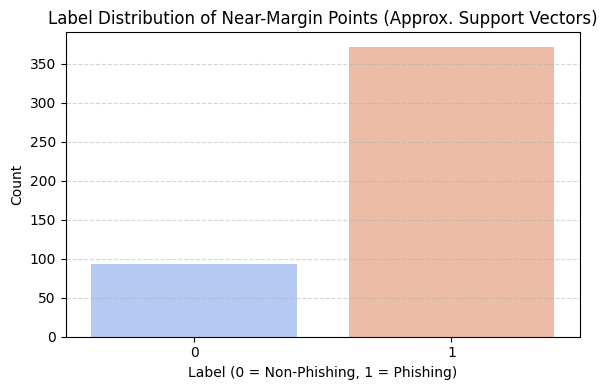

Number of near-margin points: 465


In [16]:
# Labels of these points
near_margin_labels = y_holdout.iloc[margin_indices]
near_margin_df = near_margin_points.copy()
near_margin_df["label"] = near_margin_labels.values

display(near_margin_df)

# Count plot of labels
plt.figure(figsize=(6, 4))
sns.countplot(data=near_margin_df, x="label", palette="coolwarm")
plt.title("Label Distribution of Near-Margin Points (Approx. Support Vectors)")
plt.xlabel("Label (0 = Non-Phishing, 1 = Phishing)")
plt.ylabel("Count")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

print(f"Number of near-margin points: {len(near_margin_df)}")


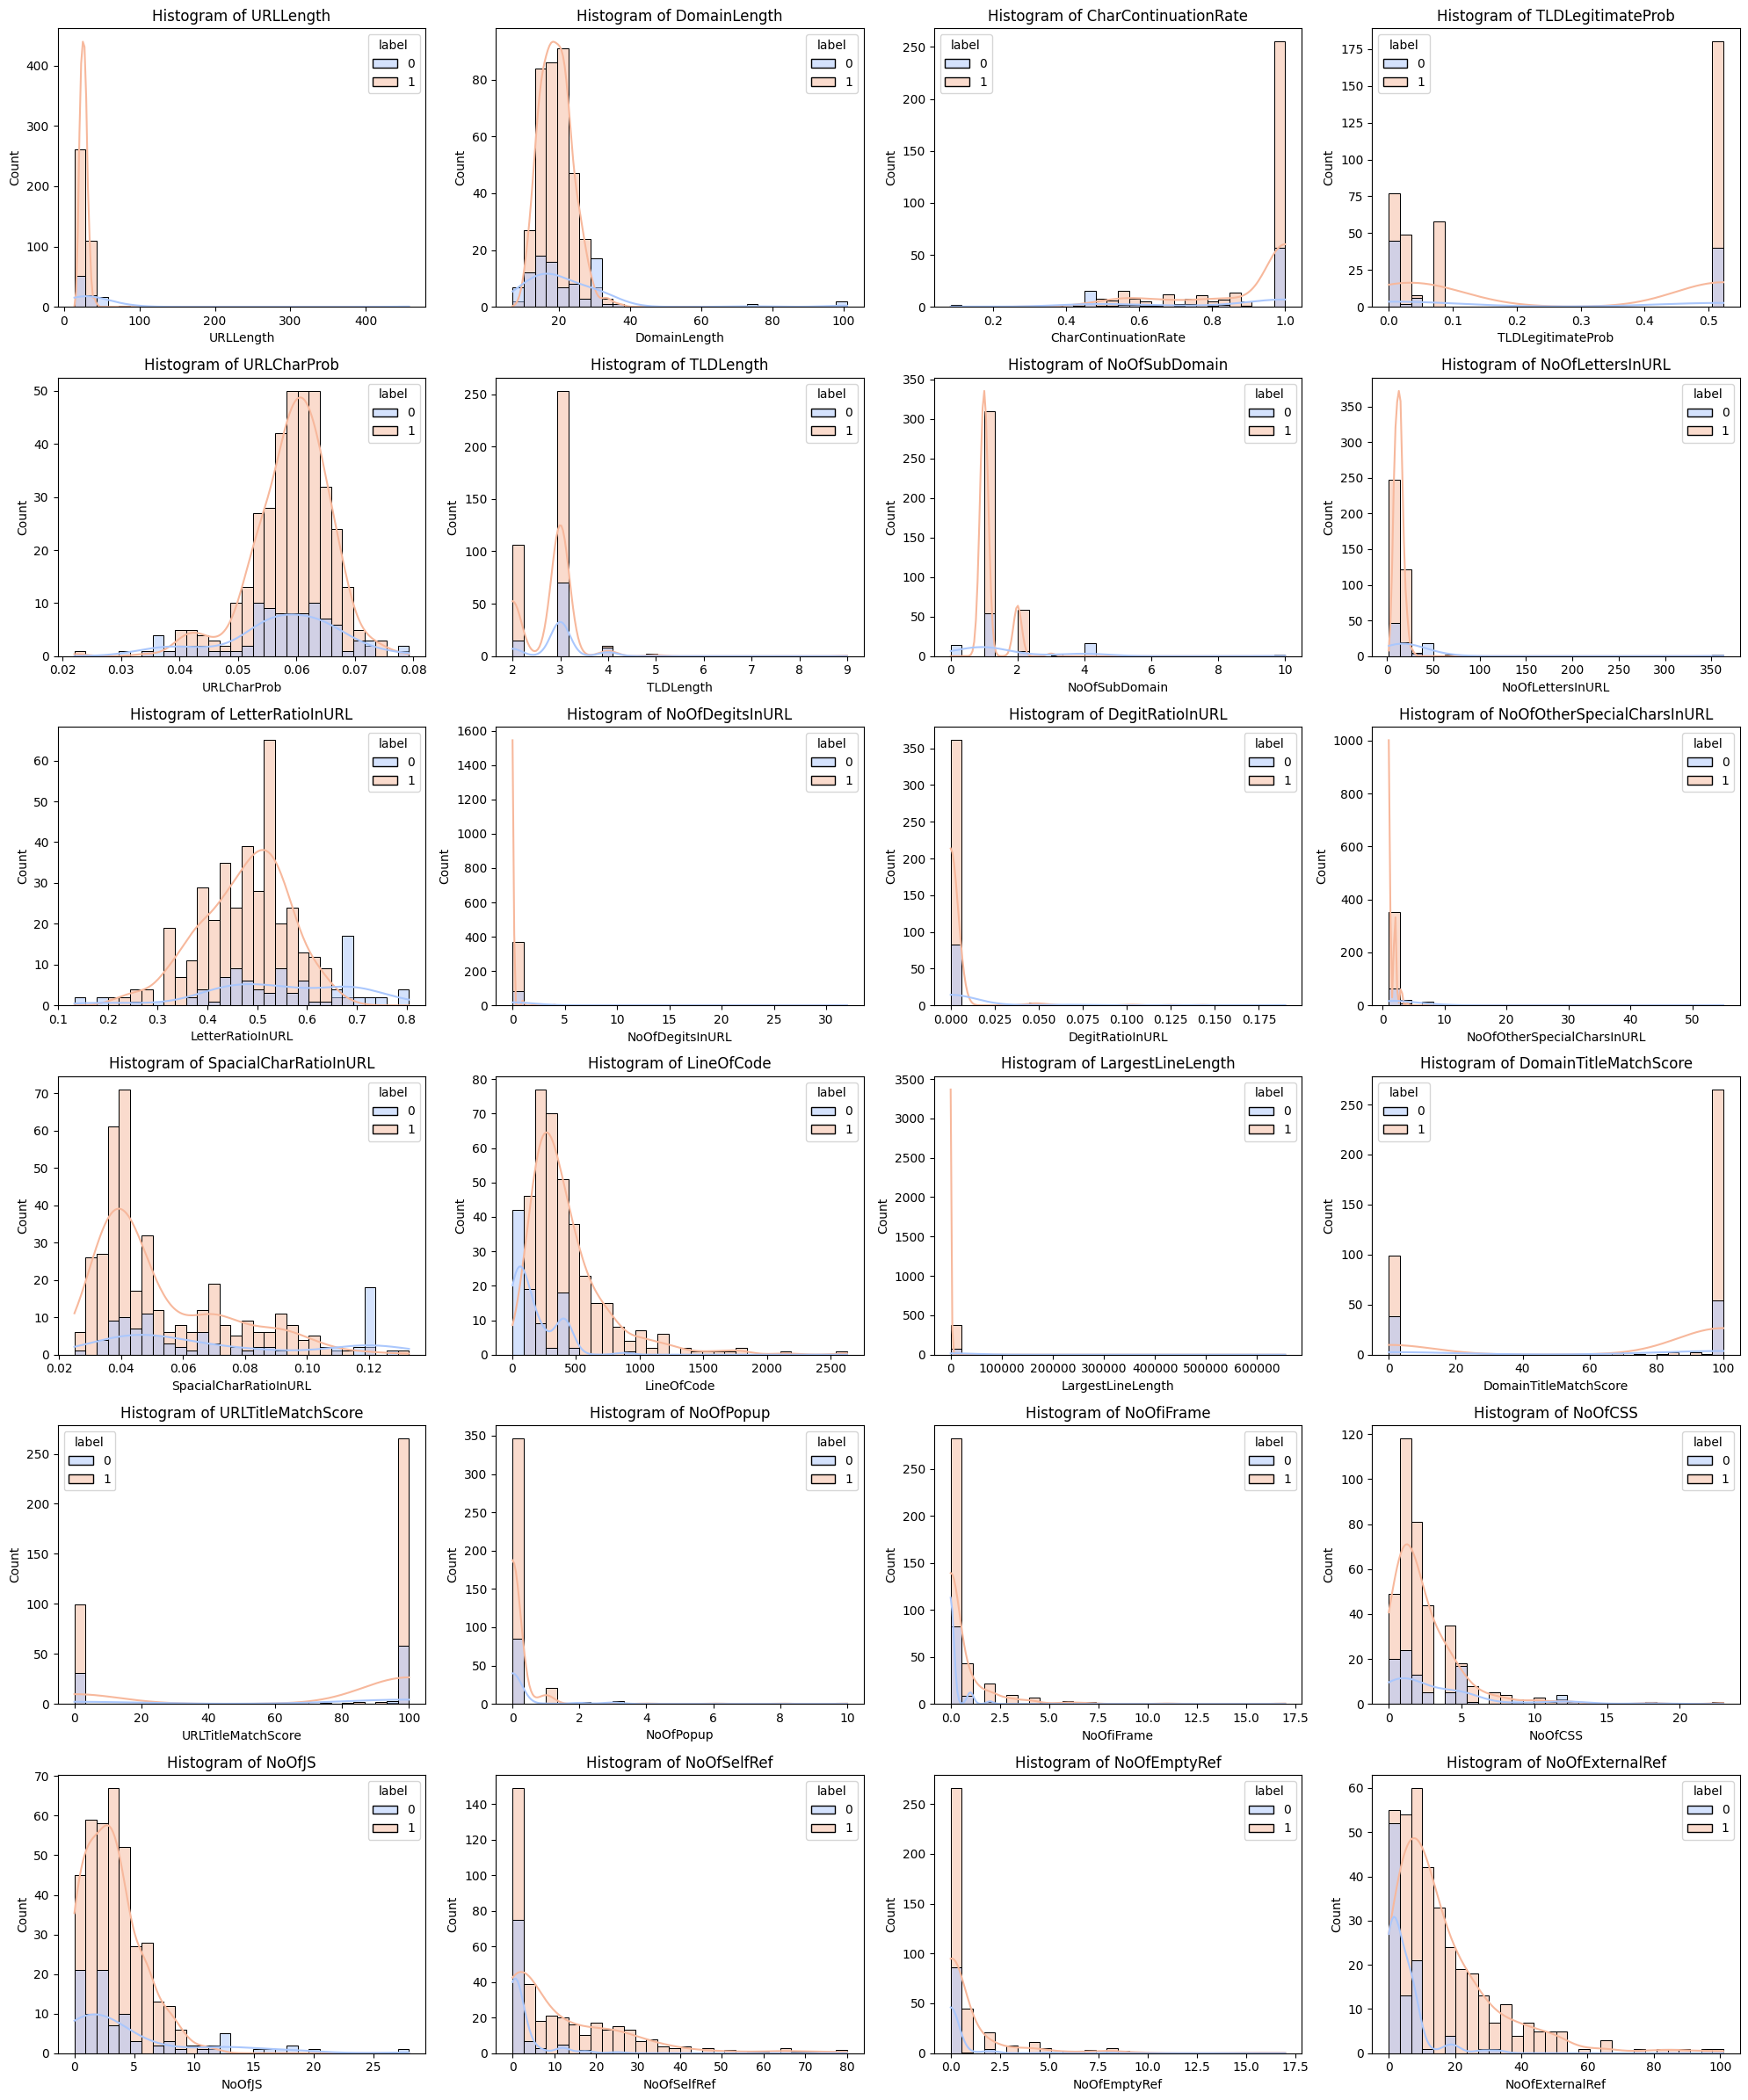

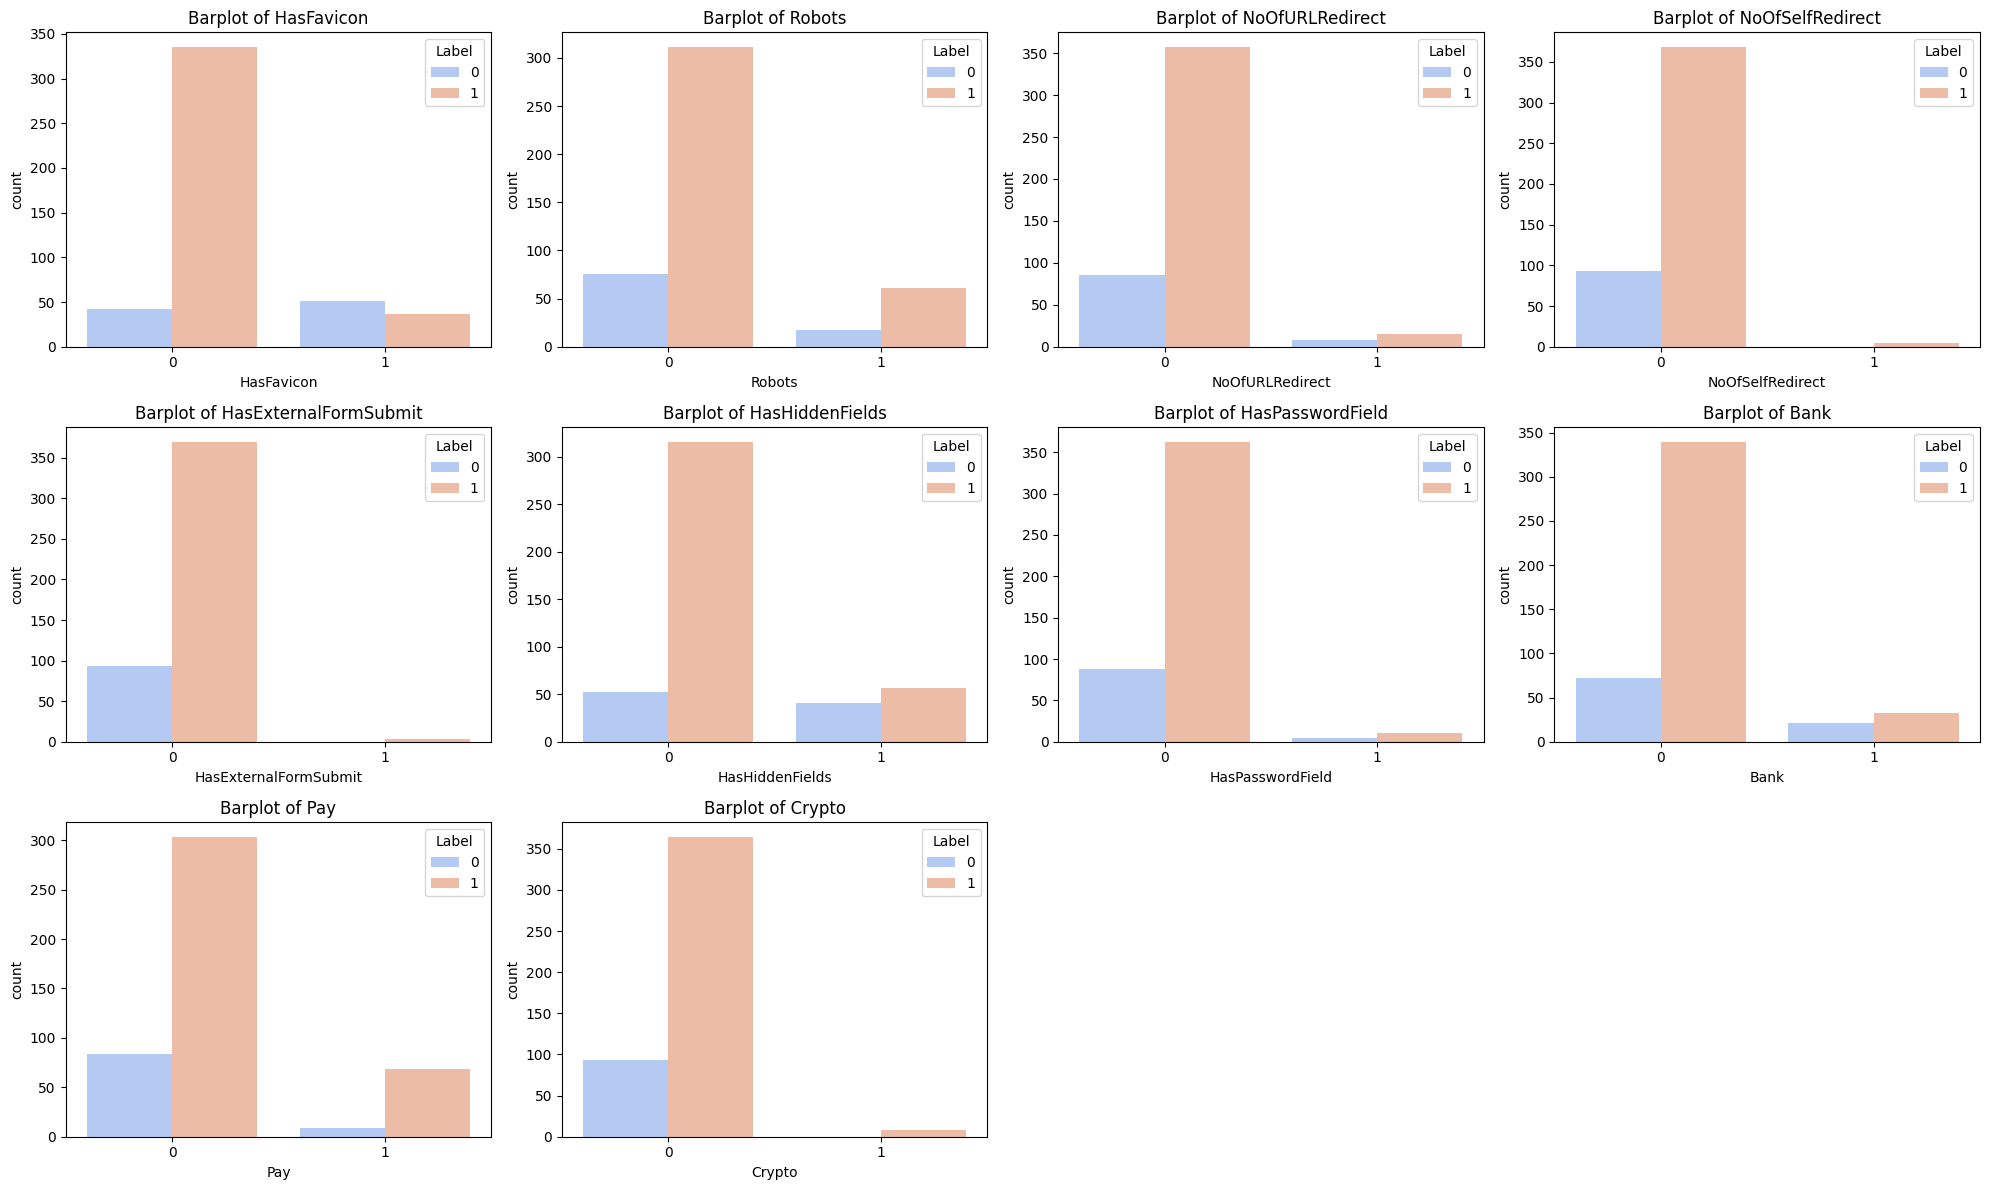

In [17]:
# Separate numeric and categorical/binary features
numeric_features = [
    col for col in near_margin_df.columns
    if near_margin_df[col].dtype in ['int64', 'float64'] and near_margin_df[col].nunique() > 2 and col != "label"
]

# (binary) features
categorical_features = [
    col for col in near_margin_df.columns
    if set(near_margin_df[col].dropna().unique()).issubset({0, 1}) and col != "label"
]


# Plot numeric features: Histograms
n_cols = 4
n_rows = (len(numeric_features) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(numeric_features):
    sns.histplot(data=near_margin_df, x=col, bins=30, kde=True, ax=axes[i], hue="label", palette="coolwarm")
    axes[i].set_title(f"Histogram of {col}")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Plot categorical features: Bar plots
n_cols = 4
n_rows = (len(categorical_features) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(categorical_features):
    sns.countplot(data=near_margin_df, x=col, hue="label", palette="coolwarm", ax=axes[i])
    axes[i].set_title(f"Barplot of {col}")
    axes[i].legend(title="Label")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


There are 465 approximate support vector candidates.

- `URLLength`, `DomainLength`, `LineOfCode`, `LargestLineLength`: Most samples cluster in middle ranges, with both label (0 and 1) showing similar distributions which suggests they don't strongly separate the classes near the margin
- `TLDLegitimateProb`, `URLCharProb`, `DegitRatioInURL`, `SpacialCharRatioInURL` : Densities of phishing vs. non-phishing overlap. This indicates that they are statistically similar wihch make classification harder.

- Features such as `Bank`, `Pay` and `Crypto` has small count of label=1 but mostly have label=0. These features may trigger suspicion but are not conclusive for classficiation on their own.
- `HasFaviocon`, `Robots`, `NoOfURLRedirect`, `HasHiddenFields` majority valures are 0 for both classes suggests they don't decissively indicates phishing in edge cases.


#### PCA for Vectors

In [18]:
## PCA for Vectors
palette = px.colors.qualitative.Dark2

X_transformed = pipeline.named_steps['preprocessor'].transform(X_holdout)
pca = PCA(n_components=3, random_state=42)
X_pca = pca.fit_transform(X_transformed)

margin_mask = np.zeros(len(X_holdout), dtype=bool)
margin_mask[margin_indices] = True

pca_df = pd.DataFrame({
    "PC1": X_pca[:, 0],
    "PC2": X_pca[:, 1],
    "PC3": X_pca[:, 2],
    "Label": y_holdout.astype(str).values,
    "SupportVectorCandidate": np.where(margin_mask, "Yes", "No")
})

pca_df["ColorCategory"] = pca_df["Label"] + " / " + pca_df["SupportVectorCandidate"]
unique_categories = pca_df["ColorCategory"].unique()
color_map = {cat: palette[i % len(palette)] for i, cat in enumerate(unique_categories)}


fig = px.scatter_3d(
    pca_df,
    x="PC1",
    y="PC2",
    z="PC3",
    color="ColorCategory",
    symbol="SupportVectorCandidate",
    opacity=0.75,
    title="3D PCA Visualization with Margin Points Highlighted",
    color_discrete_map=color_map
)
fig.update_traces(marker=dict(size=4))
fig.show()
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
correlation_matrix = pd.DataFrame(
    loadings,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)],
    index=X_final.columns,
)

n_components = pca.n_components_ if hasattr(pca, 'n_components_') else pca.n_components
top_features = 5 
pc_columns = [f"PC{i+1}" for i in range(n_components)]
table_data = []

for pc in pc_columns:
    top = (
        correlation_matrix[pc]
        .abs()
        .sort_values(ascending=False)
        .head(top_features)
        .reset_index()
    )
    top.columns = ["Feature", "Importance"]
    top["PC"] = pc
    table_data.append(top)

result_table = pd.concat(table_data)
pivot_table = result_table.pivot(
    index="Feature", columns="PC", values="Importance"
).round(4)
display(
    pivot_table.style.background_gradient(cmap="viridis", axis=None)
    .set_caption("Top Features per Principal Component")
    .set_table_attributes('style="width: 100%;"')
)

PC,PC1,PC2,PC3
Feature,,,
DomainLength,nan,nan,0.438700
DomainTitleMatchScore,nan,0.458000,0.727500
LargestLineLength,nan,0.508500,0.869300
LineOfCode,1.034600,1.100200,nan
SpacialCharRatioInURL,1.003500,1.133700,nan
TLDLength,0.629900,nan,0.416300
URLCharProb,0.647600,nan,0.387800
URLLength,0.628600,0.415400,nan


## Model Comparison: Logistic Regression vs. SVM

#### Performance Metrics

| Metric                         | Logistic Regression | SVM Model        |
|--------------------------------|---------------------|------------------|
| AUC (ROC)                      | 1.000             | 0.998            |
| Accuracy                       | 99.77%            | 98.20%           |
| Precision (PPV)                | 99.69%            | 99.31%           |
| Recall (Sensitivity)           | 99.90%            | 97.53%           |
| Specificity (TNR)              | 99.59%            | 99.10%           |
| Negative Predictive Value (NPV)| 99.87%            | 96.77%           |
| F1 Score                       | 99.80%            | 98.41%           |

#### Confusion Matrices

**Logistic Regression**
|                        | Predicted: Non-phishing  | Predicted: Phishing  |
|------------------------|--------------------------|----------------------|
| Actual: Non-phishing   | 20,106                   | 83                   |
| Actual: Phishing       | 27                       | 26,943               |

**SVM**
|                        | Predicted: Non-phishing  | Predicted: Phishing  |
|------------------------|--------------------------|----------------------|
| Actual: Non-phishing   | 20,007                   | 182                  |
| Actual: Phishing       | 667                      | 26,303               |


### Logistic Regression vs. SDG performance

#### Prediction Accuracy
Between logistic regression and the SGD classifier, the SGD classifier achieved the highest prediction accuracy at 99.6%, outperforming logistic regression, which reached 97.9%. While logistic regression also showed strong performance, its results were slightly lower even after applying log transformations to improve feature stability. The SGD model, acting as a linear SVM, demonstrated better generalization and stronger classification ability on this task. This suggests that, in this case, the SGD classifier may be more effective in capturing the underlying patterns in the data.

#### Efficiency & Training Time
In terms of training speed, the SGD classifier again proved to be more efficient, completing training in 6.7 seconds, compared to 12.3 seconds for logistic regression. While log transformation in logistic regression helped reduce skewness and improve convergence, the incremental learning approach of SGD—processing data in small batches—made it significantly faster and more scalable, particularly suited for larger datasets.

#### Overfitting Signals
Despite its high accuracy, logistic regression may show signs of overfitting, particularly given the wide performance gap between training and holdout predictions or when the dataset is imbalanced. The use of strong regularization (L1) and log transformations helped mitigate this, but the model’s sensitivity to feature scaling and variance makes it more prone to overfitting without careful preprocessing. In contrast, the SGD classifier demonstrated strong generalization with fewer signs of overfitting, supported by its performance on borderline (near-margin) samples.

#### Other Considerations
While logistic regression remains a more interpretable model and generally performs well on structured data, it assumes linearity and constant variance among predictors, making it more sensitive to feature distributions. As a result, logistic regression often requires more intensive preprocessing—such as standardization and log transformations—to achieve optimal performance. In contrast, the SGD classifier (with hinge loss) is more robust to non-normal or skewed features and requires less preprocessing to perform effectively. However, SGD is more sensitive to hyperparameter tuning and may require additional effort to stabilize training. Overall, the choice between logistic regression and SGD depends on the specific task priorities—whether interpretability and traditional modeling are emphasized, or speed, scalability, and accuracy are more critical.


A balanced bar suggests the model struggles equally with both classes. Might be little more struggling with classifying phising cases.

According to the Approximate Support Vectors vs. All Holdout Samples(3D PCA) graph,
1. Most pink and purple points lie near the bulk of pink points which indicates that support vectors are spread along the boundary
2. There's dense orange points which suggests the majority of holdout samples are structurally similar. 
3. Support vectors are not isolated, which means the model isn't being influenced by pure noise or outliers.

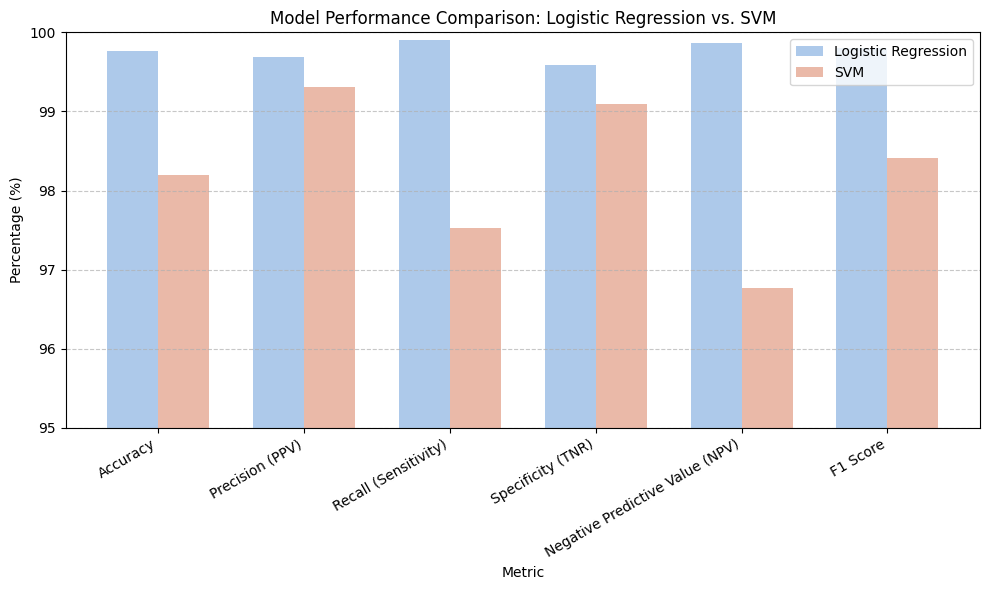

In [19]:
# Performance metrics for each model
metrics = [
    "Accuracy",
    "Precision (PPV)",
    "Recall (Sensitivity)",
    "Specificity (TNR)",
    "Negative Predictive Value (NPV)",
    "F1 Score"
]

# Values for each model
lr_values = [99.77, 99.69, 99.90, 99.59, 99.87, 99.80]
svm_values = [98.20, 99.31, 97.53, 99.10, 96.77, 98.41]

# Create a DataFrame for easier plotting
df = pd.DataFrame({
    "Metric": metrics,
    "Logistic Regression": lr_values,
    "SVM": svm_values
})

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
index = range(len(metrics))

# Bars for each model
bar1 = ax.bar([i - bar_width/2 for i in index], df["Logistic Regression"], bar_width, label='Logistic Regression', color="#adc9ea")
bar2 = ax.bar([i + bar_width/2 for i in index], df["SVM"], bar_width, label='SVM',  color="#eab9a8")

# Labels and formatting
ax.set_xlabel("Metric")
ax.set_ylabel("Percentage (%)")
ax.set_title("Model Performance Comparison: Logistic Regression vs. SVM")
ax.set_xticks(index)
ax.set_xticklabels(metrics, rotation=30, ha='right')
ax.set_ylim(95, 100)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()
